In [1]:
import os
from os.path import expanduser
import socket
import sys
import glob

# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')
#########################################

In [4]:
import pyfesom as pf
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import time
from shapely.geometry.polygon import Polygon
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap
from matplotlib import cm

In [5]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = wd_path+'data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [6]:
import shapefile as shp
sf = shp.Reader('/scratch/usr/hbkoziel/wwf/wwf_epsg4326.shp')
#sf = shp.Reader('/home/ollie/loziel/wwf/wwf_epsg4326.shp')

For depth 0 model level 0.0 will be used


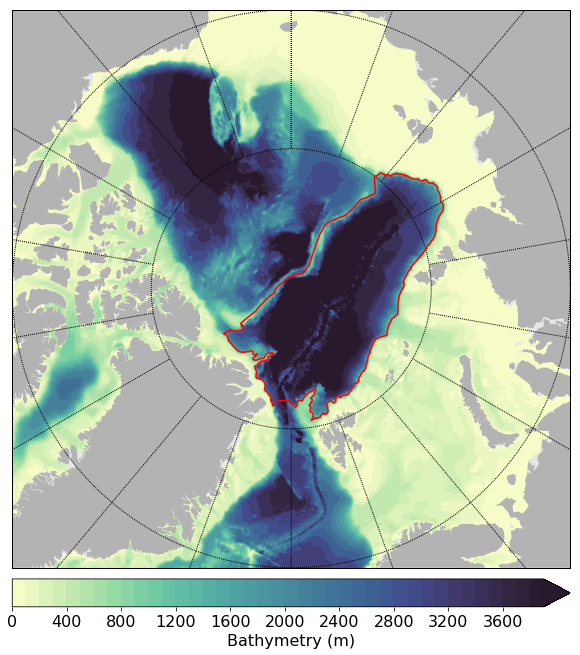

In [12]:
fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)
ax      = fig.add_subplot(111)

map = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = map(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
map.drawparallels(np.arange(-80.,81.,10.), labels=plabels)
map.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
map.drawmapboundary(fill_color='0.9')
map.fillcontinents(color='.7',lake_color='.7')

data, elem_no_nan = pf.get_data(mesh.topo,mesh,0)
contours = np.arange(0, 4000, 100)
im = plt.tricontourf(x, y, elem_no_nan, data, levels=contours, cmap=cmap.cm.deep, extend='max')

#im2 = plt.tricontourf(x, y, elem_no_nan, data, levels=np.arange(300, 311, 10), cmap=cm.Reds)
#im3 = plt.tricontourf(x, y, elem_no_nan, data, levels=np.arange(1200, 1211, 10), cmap=cm.Reds)


for shape in sf.shapeRecords():
    if shape.record[1] <= 24:
        for i in range(len(shape.shape.parts[:])):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            lon, lat = map(x, y)
            #plt.plot(lon,lat)
            poly = Polygon(list(zip(lon, lat)))
            #ax.add_patch(PolygonPatch(poly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
            #plt.fill(lon, lat, alpha=0.3, zorder=10, color='red')
            plt.plot(lon, lat, color='red')
            
label = 'Bathymetry (m)'
cbar=map.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)
            
plt.show()

For depth 0 model level 0.0 will be used


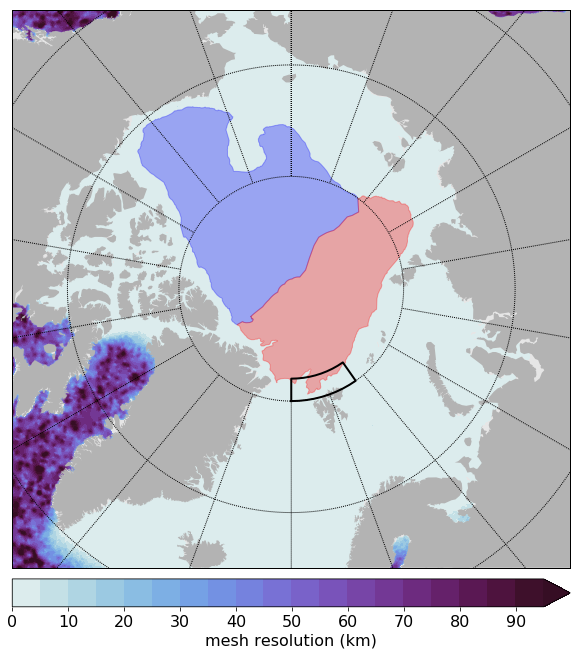

In [16]:
fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)
ax      = fig.add_subplot(111)

map = Basemap(projection='nplaea',boundinglat=65,lon_0=0,resolution='l')
x, y = map(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
map.drawparallels(np.arange(-80.,81.,10.), labels=plabels)
map.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
map.drawmapboundary(fill_color='0.9')
map.fillcontinents(color='.7',lake_color='.7')

#im = plt.triplot(x, y, mesh.elem, lw=0.1,color='k')

ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalArea = f.variables['cluster_area'][:]
f.close()

level_data, elem_no_nan = pf.get_data(NodalArea/10000000,mesh,0)

# elem2=mesh.elem[mesh.no_cyclic_elem,:]
# im2 = plt.tripcolor(x, y, elem2, \
#              facecolors=level_data[mesh.no_cyclic_elem], \
#              edgecolors='none',\
#              cmap=cm.Spectral_r)

contours = np.arange(0, 100, 5)
im2 = plt.tricontourf(x, y, elem_no_nan, level_data, levels=contours, cmap=cmap.cm.dense, extend='max')

label = 'mesh resolution (km)'
cbar=map.colorbar(im2,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=16)
cbar.ax.tick_params(labelsize=16)

for shape in sf.shapeRecords():
    if shape.record[1] == 24:
        for i in range(len(shape.shape.parts[:])):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            lon, lat = map(x, y)
            #plt.plot(lon,lat)
            poly = Polygon(list(zip(lon, lat)))
            #ax.add_patch(PolygonPatch(poly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
            plt.fill(lon, lat, alpha=0.3, zorder=2, color='red')
            #plt.plot(lon, lat, color='red')
        
for shape in sf.shapeRecords():
    if shape.record[1] == 25:
        for i in range(len(shape.shape.parts[:])):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            lon, lat = map(x, y)
            #plt.plot(lon,lat)
            poly = Polygon(list(zip(lon, lat)))
            #ax.add_patch(PolygonPatch(poly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
            plt.fill(lon, lat, alpha=0.3, zorder=1, color='blue')
            #plt.plot(lon, lat, color='red')
            
lat_1 = 80
lat_2 = 82
lon_1 = 0
lon_2 = 35

lati = np.append(np.linspace(lat_1,lat_2,10),np.ones(10)*lat_2)
lati = np.append(lati,np.linspace(lat_2,lat_1,10))
lati = np.append(lati,np.ones(10)*lat_1)

loni = np.append(np.ones(10)*lon_1,np.linspace(lon_1,lon_2,10))
loni = np.append(loni,np.ones(10)*lon_2)
loni = np.append(loni,np.linspace(lon_2,lon_1,10))

xi, yi = map(loni, lati)
plt.plot(xi,yi,'k',lw=2)

For depth 0 model level -0.0 will be used


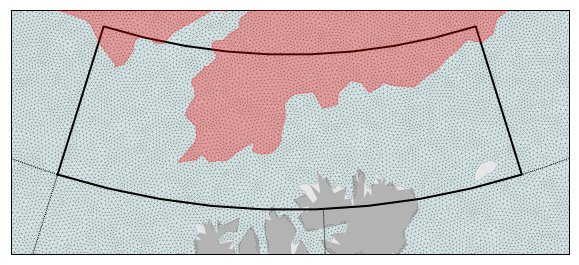

In [134]:
fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)
ax      = fig.add_subplot(111)

map = Basemap(width=800000,height=350000,resolution='l',projection='aea',\
            lat_1=80.,lat_2=82,lon_0=17.5,lat_0=81)
x, y = map(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
map.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
map.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
map.drawmapboundary(fill_color='0.9')
map.fillcontinents(color='.7',lake_color='.7')

ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalArea = f.variables['cluster_area'][:]
f.close()

level_data, elem_no_nan = pf.get_data(NodalArea/10000000,mesh,0)

# elem2=mesh.elem[mesh.no_cyclic_elem,:]
# im2 = plt.tripcolor(x, y, elem2, \
#              facecolors=level_data[mesh.no_cyclic_elem], \
#              edgecolors='none',\
#              cmap=cm.Spectral_r)

contours = np.arange(0, 100, 5)
im2 = plt.tricontourf(x, y, elem_no_nan, level_data, levels=contours, cmap=cmap.cm.dense, extend='max')

# label = 'mesh resolution (km)'
# cbar=map.colorbar(im2,"bottom", size="5%", pad="2%")
# cbar.set_label(label, fontsize=16)
# cbar.ax.tick_params(labelsize=16)

im = plt.triplot(x, y, mesh.elem, lw=0.1,color='k')

for shape in sf.shapeRecords():
    if shape.record[1] <= 24:
        for i in range(len(shape.shape.parts[:])):
            i_start = shape.shape.parts[i]
            if i==len(shape.shape.parts)-1:
                i_end = len(shape.shape.points)
            else:
                i_end = shape.shape.parts[i+1]
            x = [i[0] for i in shape.shape.points[i_start:i_end]]
            y = [i[1] for i in shape.shape.points[i_start:i_end]]
            lon, lat = map(x, y)
            #plt.plot(lon,lat)
            poly = Polygon(list(zip(lon, lat)))
            #ax.add_patch(PolygonPatch(poly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
            plt.fill(lon, lat, alpha=0.3, zorder=1, color='red')
            #plt.plot(lon, lat, color='red')

lat_1 = 80
lat_2 = 82
lon_1 = 0
lon_2 = 35

lati = np.append(np.linspace(lat_1,lat_2,10),np.ones(10)*lat_2)
lati = np.append(lati,np.linspace(lat_2,lat_1,10))
lati = np.append(lati,np.ones(10)*lat_1)

loni = np.append(np.ones(10)*lon_1,np.linspace(lon_1,lon_2,10))
loni = np.append(loni,np.ones(10)*lon_2)
loni = np.append(loni,np.linspace(lon_2,lon_1,10))

xi, yi = map(loni, lati)
plt.plot(xi,yi,'k',lw=2)